In [2]:
import kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msno


import zipfile
import json

In [2]:
!kaggle competitions download "house-prices-advanced-regression-techniques"

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
pd.set_option('display.max_rows', None)

## Load dataset 

In [3]:
import zipfile
with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip","r") as zip_ref:
    zip_ref.extractall("House-price/")

In [4]:
df = pd.read_csv("House-price/train.csv")

## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

### Correlation

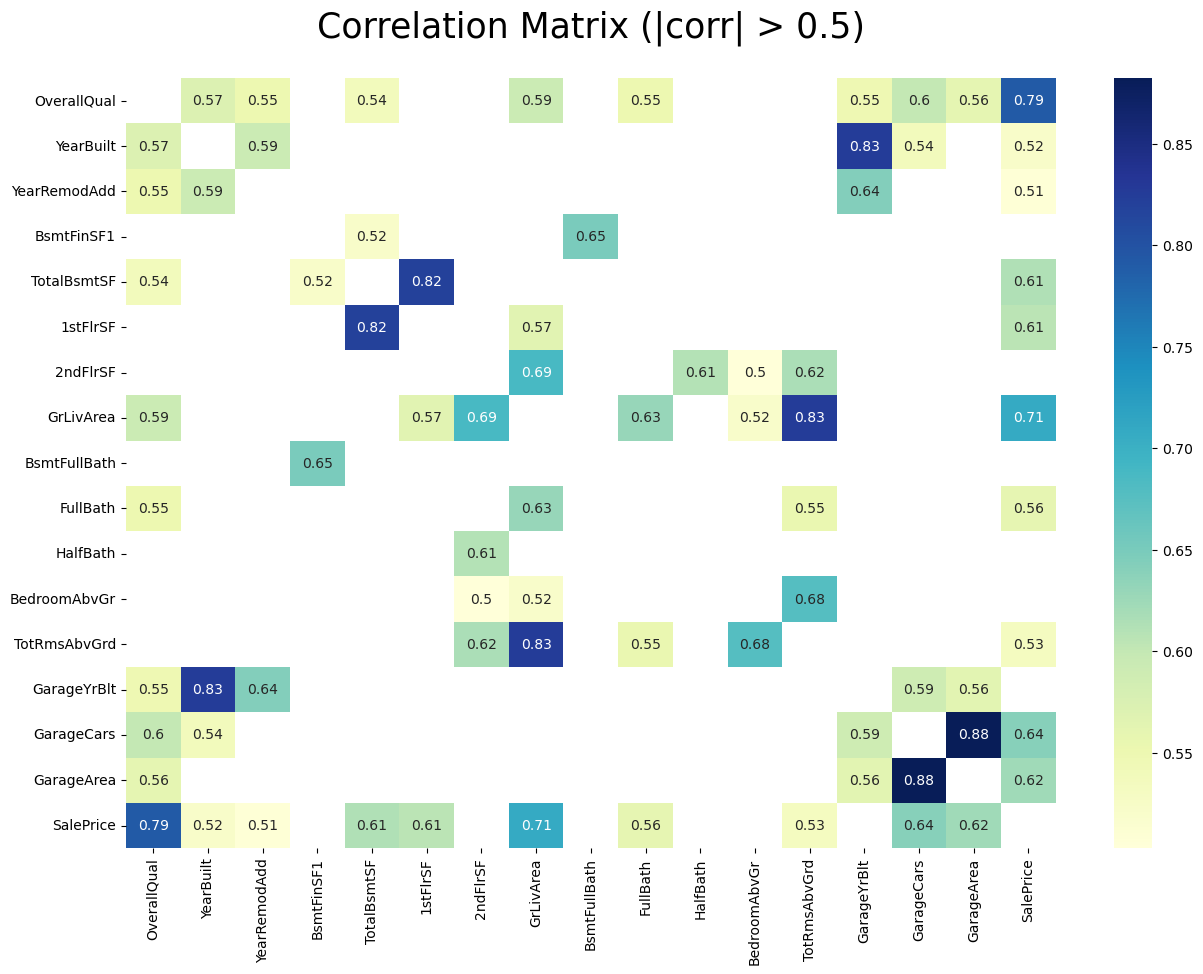

In [8]:
df_numeric = df._get_numeric_data()

df_numeric_corr = df_numeric.corr()
filteredDf = df_numeric_corr[((df_numeric_corr >= .5) | (df_numeric_corr <= -.5)) & (df_numeric_corr !=1.000)]

filteredDf.dropna(axis=0, how='all', inplace= True)
filteredDf.dropna(axis=1, how='all', inplace= True)

fig = plt.figure(figsize =(15, 10)) 
dataplot = sb.heatmap(filteredDf, cmap="YlGnBu", annot=True) 
plt.title("Correlation Matrix (|corr| > 0.5)", fontsize = 25, pad = 30)

plt.show()

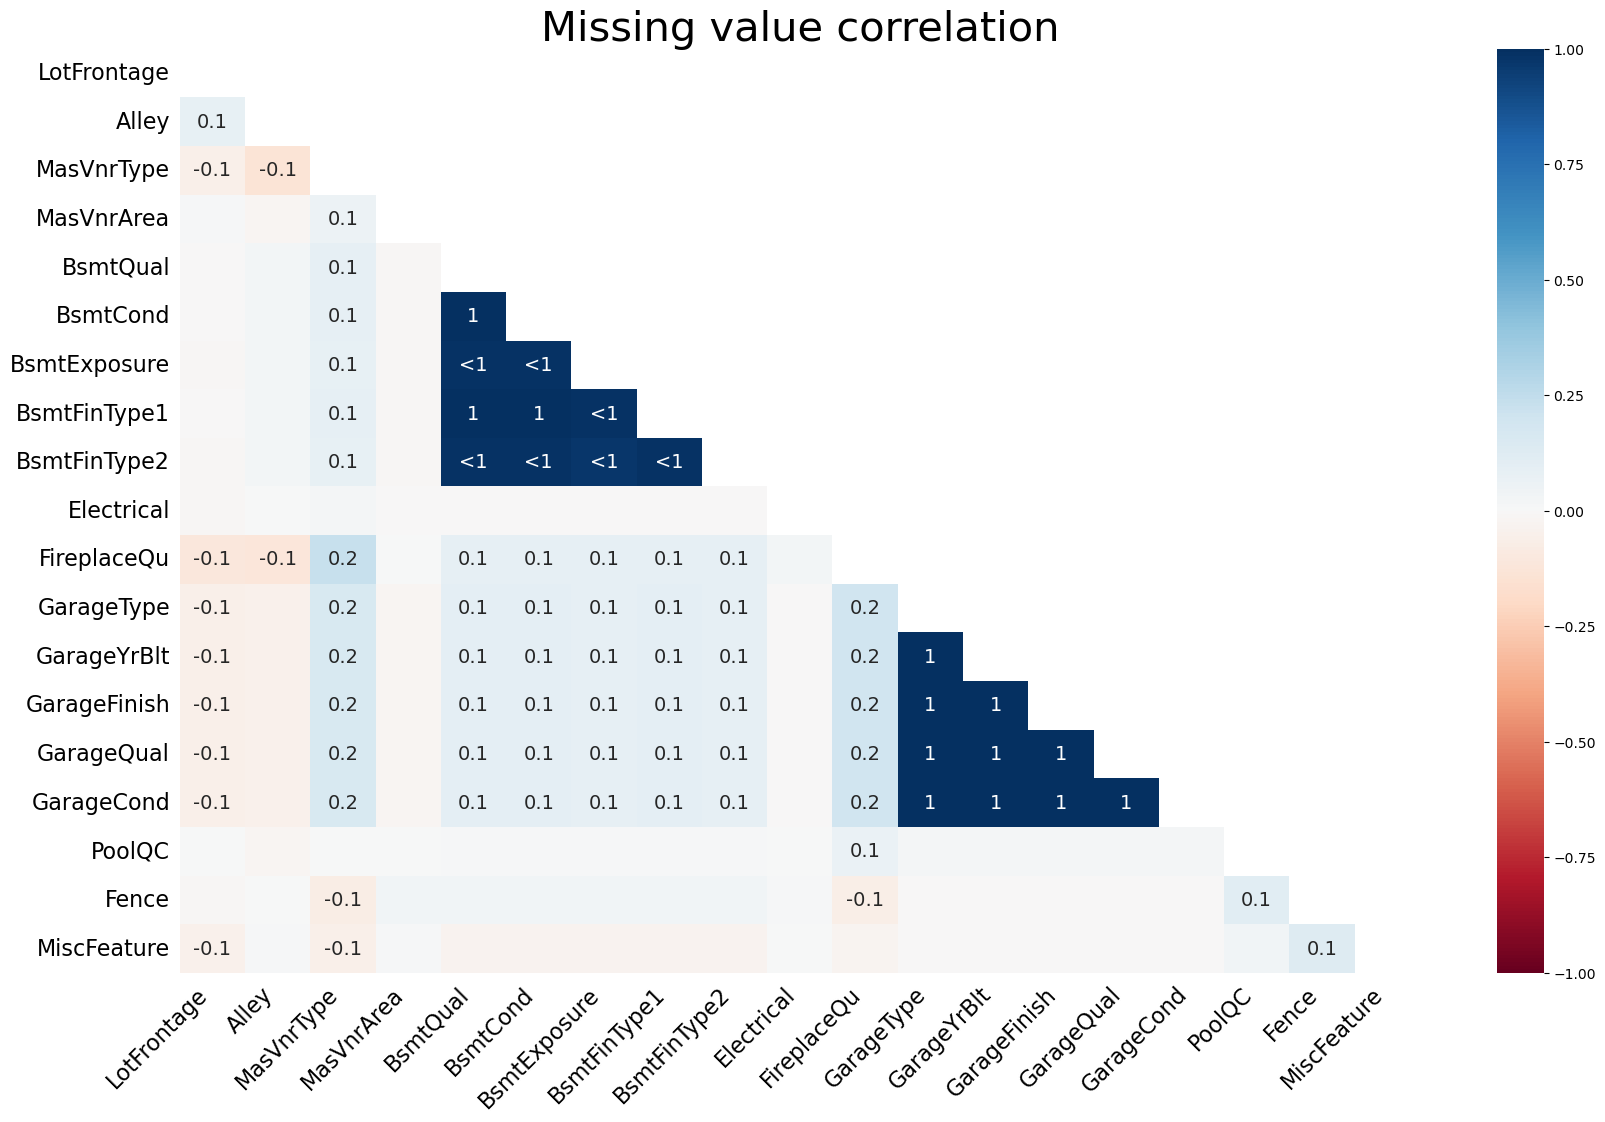

In [9]:
msno.heatmap(df)
plt.title("Missing value correlation", fontsize = 30)
plt.show()

### MasVnrArea

In [10]:
filtered_MasVnrArea_nan = df[df["MasVnrArea"].isna()]
filtered_MasVnrType = filtered_MasVnrArea_nan["MasVnrType"]
print("MasVnrType for MasVnrArea is null:")
print(filtered_MasVnrType)

MasVnrType for MasVnrArea is null:
234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object


### LotFrontage

Text(0.5, 1.0, 'Dependency between LotFrontage and SalePrice')

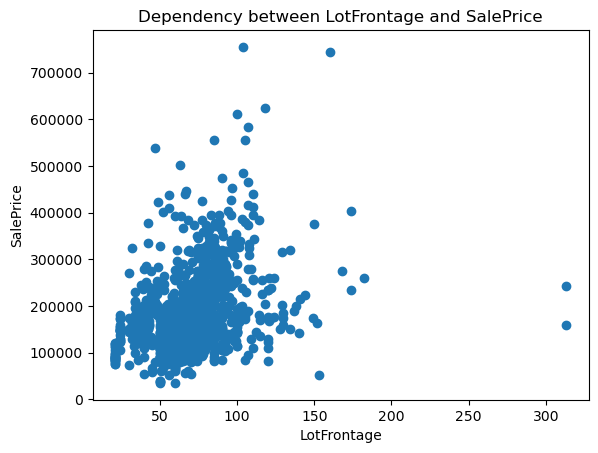

In [11]:
plt.scatter(df["LotFrontage"],df["SalePrice"])
plt.xlabel("LotFrontage")
plt.ylabel("SalePrice")
plt.title("Dependency between LotFrontage and SalePrice")

Text(0.5, 1.0, 'Boxplot of LotFrontage by LotShape')

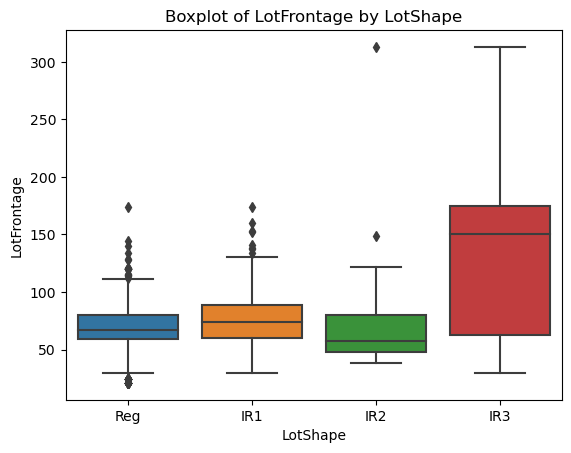

In [12]:
sb.boxplot(x=df["LotShape"],y=df["LotFrontage"])
plt.title('Boxplot of LotFrontage by LotShape')

Text(0.5, 1.0, 'Boxplot of LotFrontage by Neighborhood')

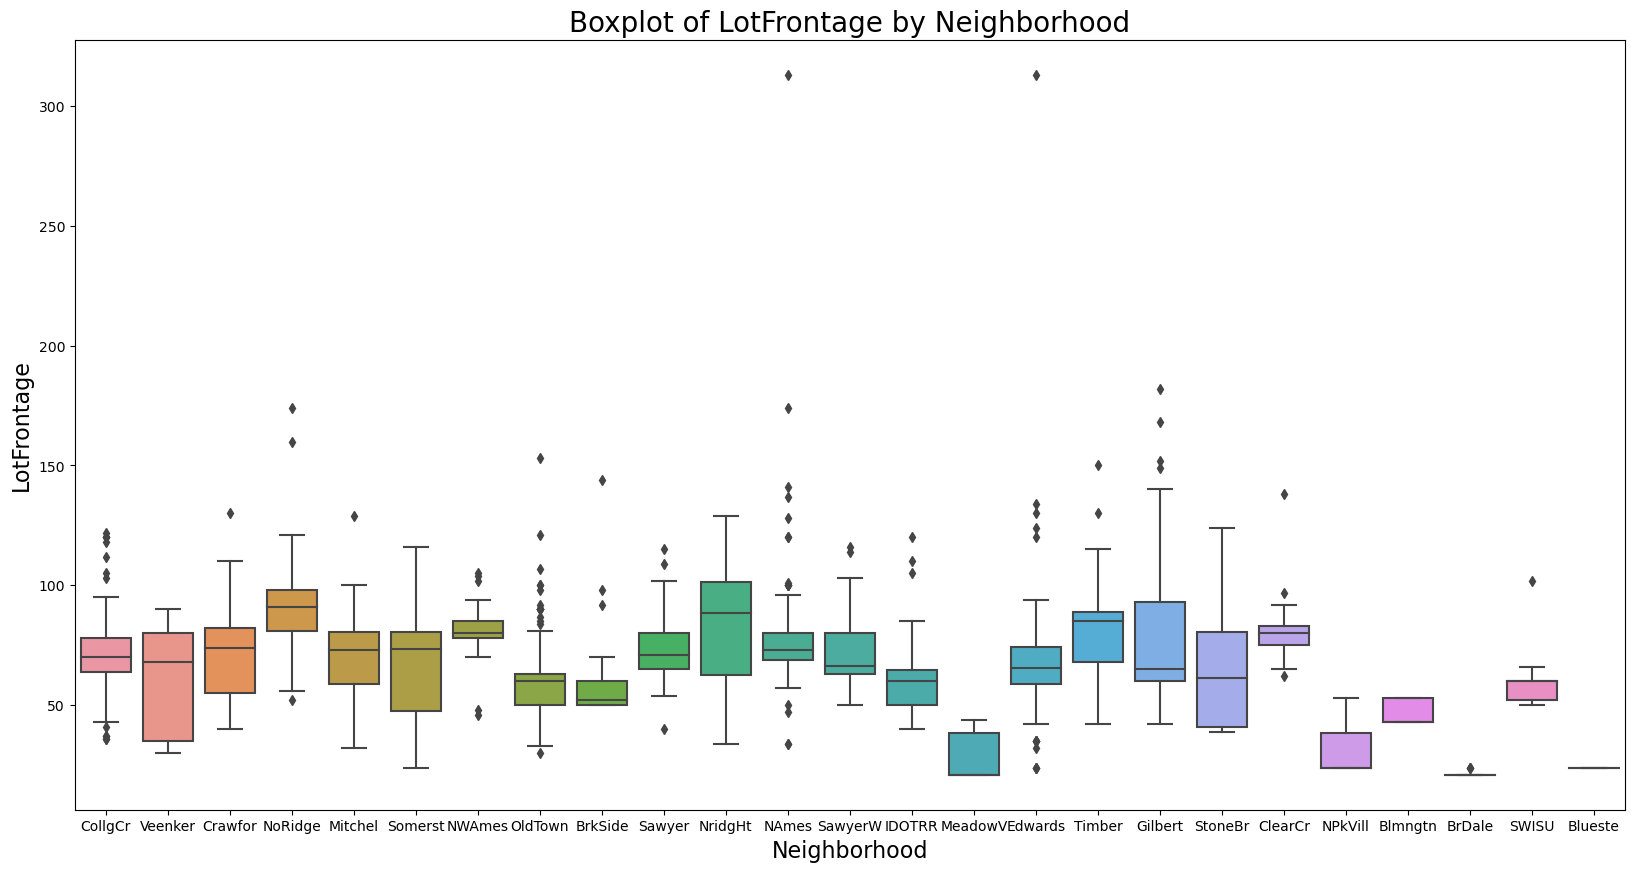

In [13]:
fig = plt.figure(figsize =(20, 10)) 
ax = fig.add_subplot(111)

sb.boxplot(x=df["Neighborhood"],y=df["LotFrontage"])

ax.set_xlabel('Neighborhood', fontsize=16)  
ax.set_ylabel('LotFrontage', fontsize=16) 
ax.set_title('Boxplot of LotFrontage by Neighborhood', fontsize=20)

### MoSold

In [14]:
df['MoSold'].value_counts()

MoSold
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: count, dtype: int64

Text(0.5, 1.0, 'Number of Sales by Month')

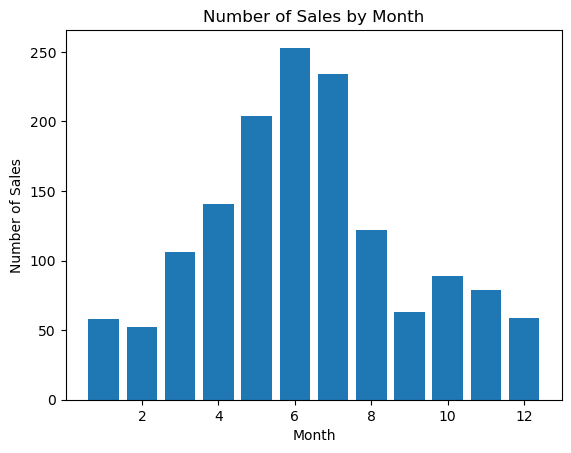

In [15]:
plt.bar(x=df['MoSold'].value_counts().sort_index().index, height= df['MoSold'].value_counts().sort_index())
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.title('Number of Sales by Month')

## Preprocessing for train set

### Devide train data into train and test sets 

In [11]:
from sklearn.model_selection import train_test_split

y = df["SalePrice"]
y = np.log(y)

X = df.drop("SalePrice", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

### Missing value

In [12]:
#fill Electrical column
electrical_common_value = X_train.groupby("Electrical")["Id"].nunique()
electrical_common_value = electrical_common_value.idxmax()

X_train["Electrical"].fillna(electrical_common_value, inplace=True)

with open('electrical_common.json', 'w') as file:
    json.dump(electrical_common_value, file)

In [13]:
# Fill LotFrontage with medians
lotFrontage_medians = df.dropna(subset=['LotFrontage']).groupby(['Neighborhood', 'LotShape'])['LotFrontage'].median()
lotFrontage_medians.to_dict()
lotFrontage_medians = {str(key): value for key, value in lotFrontage_medians.items()}

lotFrontage_median_lonely = X_train['LotFrontage'].median()

with open('lotFrontage_medians_dict.json', 'w') as f:
    json.dump(lotFrontage_medians, f)
    
with open('lotFrontage_median_lonely.json', 'w') as f:
    json.dump(lotFrontage_median_lonely, f)

In [14]:
def fill_lotfrontage(row):
    if pd.isnull(row['LotFrontage']):
        key = (row['Neighborhood'], row['LotShape'])
        if key in lotFrontage_medians:
            return lotFrontage_medians[key]
        else:
            return lotFrontage_median_lonely
    return row['LotFrontage']


In [15]:
X_train['LotFrontage'] = X_train.apply(fill_lotfrontage, axis=1)

In [16]:
#fill 0 because values missing for not built garages 
X_train["GarageYrBlt"].fillna(0, inplace=True)

In [17]:
#fill with median == 0 DON"T SAVE 0
X_train["MasVnrArea"].fillna(0, inplace=True)

In [18]:
#del colums with IDs
X_train = X_train.drop(["Id"], axis =1)

### Adding new features

In [19]:
#one hot encoding (+ fill missing value by creating columns name_NA for objects type)
#we have object nan due to feature lack
X_train = pd.get_dummies(X_train, dummy_na=True)

column_names =  list(X_train.columns)

with open('column_names.json', 'w') as file:
    json.dump(column_names, file)

In [20]:
X_train = X_train.sort_index(axis=1)

In [21]:
#define preprocessing function
def preprocessing(df):
    
    def fill_lotfrontage(row):
        if pd.isnull(row['LotFrontage']):
            key = (row['Neighborhood'], row['LotShape'])
            if key in lotFrontage_medians:
                return lotFrontage_medians[key]
            else:
                return lotFrontage_median_lonely
        return row['LotFrontage']

    
    #Electrical missing fill with file
    with open('electrical_common.json', 'r') as file:
        electrical_common = json.load(file)
    df["Electrical"].fillna(electrical_common_value, inplace=True)
    
    #LotFrontage missing fill with files
    with open('lotFrontage_medians_dict.json', 'r') as file:
        lotFrontage_medians = json.load(file)

    with open('lotFrontage_median_lonely.json', 'r') as file:
        lotFrontage_median_lonely = json.load(file)

    lotFrontage_medians = {eval(key): value for key, value in lotFrontage_medians.items()}

    df['LotFrontage'] = df.apply(lambda row: lotFrontage_medians.get((row['Neighborhood'], row['LotShape']), lotFrontage_median_lonely), axis=1)

    #GarageYrBlt and MasVnrArea middinf fill 0
    df["GarageYrBlt"].fillna(0, inplace=True)
    df["MasVnrArea"].fillna(0, inplace=True)

    #drop ids
    if "Id" in df:
        df = df.drop(["Id"], axis =1)
        
    
    #one hot encoding
    df = pd.get_dummies(df, dummy_na=True)
    
    #compare columns in train and test
    with open('column_names.json', 'r') as file:
        column_test = json.load(file)
    
    for column in column_test:
        if column not in df:
            df[column] = 0
            
    for column in df.columns:
        if column not in column_test:
            df = df.drop(column, axis =1)
            
    #set the same columns order
    #column_order = X_train.columns
    #df = df[column_order]
    #df = df.fillna(0)
    df = df.sort_index(axis=1)
            
    return df
    

In [22]:
X_test = preprocessing(X_test)

## LightGBM

In [24]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Base model

In [27]:
model_gbdt = lgb.LGBMRegressor(random_state=42, boosting_type = 'gbdt')
model_gbdt.fit(X_train, y_train)

y_pred_train = model_gbdt.predict(X_train)
y_pred_test = model_gbdt.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 193
[LightGBM] [Info] Start training from score 12.030652
Train Mean Squared Error: 0.0017679784838670416
Train R2 Score: 0.9884024692312335
Test Mean Squared Error: 0.018709906259477944
Test R2 Score: 0.8997398128755927


In [28]:
model_dart = lgb.LGBMRegressor(random_state=42, boosting_type = 'dart', drop_rate = 0.9 ,skip_drop = 0.9)
model_dart.fit(X_train, y_train)

y_pred_train = model_dart.predict(X_train)
y_pred_test = model_dart.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 193
[LightGBM] [Info] Start training from score 12.030652
Train Mean Squared Error: 0.024956533106811247
Train R2 Score: 0.8362909032948687
Test Mean Squared Error: 0.04184101719192866
Test R2 Score: 0.7757878551094696


In [39]:
model_rf = lgb.LGBMRegressor(random_state=42, boosting  = 'rf', bagging_freq = 20, bagging_fraction = 0.8)
model_rf.fit(X_train, y_train)

y_pred_train = model_rf.predict(X_train)
y_pred_test = model_rf.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 321

**gbdt gives the biggest level of overfitting,
hyperparameters searching doesn'help solve overfitting problem**

### Search hyperparameters

*Cross validation*

In [68]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 4, shuffle = True, random_state=42)

def train_model(params, kf=kf):
    list_tr_r2 = []
    list_val_r2 = []
    n=0
    for train_index, val_index in kf.split(X_train):
        n +=1
        print('Fold№', n)
        model = lgb.LGBMRegressor(random_state=42, **params)
        
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model.fit(X_tr, y_tr)
        
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)
        
        print('R2 train =', r2_score(y_tr, y_tr_pred))
        print('R2 valid =', r2_score(y_val, y_val_pred))
        
        list_tr_r2.append(r2_score(y_tr, y_tr_pred))
        list_val_r2.append(r2_score(y_val, y_val_pred))

    print('total R2 train = ', np.mean(np.array(list_tr_r2)))
    print('total R2 valid = ', np.mean(np.array(list_val_r2)))

*boosting_type = dart*

*l1, l2 and early_stopping regularization not compatible with the 'dart' mode*

*Add bagging as regularization method*

In [51]:
from sklearn.model_selection import RandomizedSearchCV

space_dart = {
    'boosting_type': ['dart'],  
    'num_leaves': np.arange(5, 20, 5),
    'max_depth': np.arange(5, 50, 5),
    'learning_rate': np.linspace(0.001, 0.1, 20),
    'n_estimators': np.arange(500, 600, 25),
    'min_child_samples': np.arange(10, 30, 5),
    'drop_rate': np.linspace(0.1, 1.0, 10),
    'skip_drop': np.linspace(0.0, 1.0, 11),  
    'feature_fraction': np.linspace(0.5, 1.0, 6),
    'bagging_fraction': np.linspace(0.5, 1.0, 6),
    'bagging_freq': np.arange(1, 10, 2),
    'metric': ['mse']
}


In [52]:
random_search = RandomizedSearchCV(estimator=lgb.LGBMRegressor(random_state=42), param_distributions=space_dart, 
                                   n_iter=400, cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'bagging_fraction': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'bagging_freq': array([1, 3, 5, 7, 9]),
                                        'boosting_type': ['dart'],
                                        'drop_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'feature_fraction': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array(...
       0.05310526, 0.05831579, 0.06352632, 0.06873684, 0.07394737,
       0.07915789, 0.08436842, 0.08957895, 0.09478947, 0.1       ]),
                                        'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'metric': ['mse'],
                                        'min_child_samples': array([10, 15, 20, 25]),
                                        'n_estimators': array([500, 525, 550, 575]),
                                        'num_leaves': array([ 5, 10, 15]),
                                        'skip_drop': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42)

In [58]:
print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best params: {'skip_drop': 0.9, 'num_leaves': 5, 'n_estimators': 550, 'min_child_samples': 10, 'metric': 'mse', 'max_depth': 45, 'learning_rate': 0.04789473684210526, 'feature_fraction': 0.5, 'drop_rate': 0.2, 'boosting_type': 'dart', 'bagging_freq': 3, 'bagging_fraction': 0.5}
Best score: 0.8989445636252016


In [59]:
train_model(random_search.best_params_)

Fold№ 1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
R2 train = 0.9589793523585537
R2 valid = 0.9156956728793607
Fold№ 6
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fracti

In [7]:
dart_params = {
    'boosting_type': ['dart'],  
    'num_leaves': 5,
    'max_depth': 5,
    'learning_rate': 0.05,
    'n_estimators': 570,
    'min_child_samples': 10,
    'drop_rate': 0.2,
    'skip_drop': 0.9,  
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 3,
    'metric': ['mse']
}

In [69]:
train_model(dart_params)

Fold№ 1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

*boosting_type = rf*

In [110]:
space_rf = {
    'boosting_type': ['rf'],  
    'num_leaves': np.arange(5, 20, 5),
    'max_depth': np.arange(5, 50, 5),
    'learning_rate': np.linspace(0.01, 1.0, 11),
    'n_estimators': np.arange(200, 600, 100),
    'min_child_samples': np.arange(10, 35, 5),
    'feature_fraction': np.linspace(0.5, 1.0, 6),
    'bagging_fraction': np.linspace(0.0, 1.0, 11),
    'bagging_freq': np.arange(5, 25, 2),
    'metric': ['mse'],
    'lambda_l1': [0, 0.001, 0.01, 0.1, 1, 10], 
    'lambda_l2': [0, 0.001, 0.01, 0.1, 1, 10]
}

In [111]:
random_search_rf = RandomizedSearchCV(estimator=lgb.LGBMRegressor(random_state=42), param_distributions=space_rf, 
                                   n_iter=500, cv=5, random_state=42, n_jobs=-1)

random_search_rf.fit(X_train, y_train)

C:\Users\Marharyta\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
245 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
220 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Marharyta\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Marharyta\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 1092, in fit
    super().fit(
  File "C:\Users\Marharyta\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 885, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\Marharyta\anaconda3\L

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bagging_fraction': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'bagging_freq': array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23]),
                                        'boosting_type': ['rf'],
                                        'feature_fraction': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'lambda_l1': [0, 0.001, 0.01, 0.1, 1,
                                                      10],
                                        'lambda_l2': [0, 0.001, 0.01, 0.1, 1,
                                                      10],
                                        'learning_rate': array([0.01 , 0.109, 0.208, 0.307, 0.406, 0.505, 0.604, 0.703, 0.802,
       0.901, 1.   ]),
                                        'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'metric': ['mse'],
                                        'min_child_samples': array([10, 15, 20, 25, 30]),
                                        'min_split_gain': [0.0, 0.1, 0.2, 0.3,
                                                           0.4, 0.5],
                                        'n_estimators': array([200, 300, 400, 500]),
                                        'num_leaves': array([ 5, 10, 15])},
                   random_state=42)

In [112]:
print("Best params:", random_search_rf.best_params_)
print("Best score:", random_search_rf.best_score_)

Best params: {'num_leaves': 15, 'n_estimators': 400, 'min_split_gain': 0.0, 'min_child_samples': 10, 'metric': 'mse', 'max_depth': 20, 'learning_rate': 0.901, 'lambda_l2': 0.001, 'lambda_l1': 0.01, 'feature_fraction': 0.6, 'boosting_type': 'rf', 'bagging_freq': 11, 'bagging_fraction': 0.5}
Best score: 0.8200215772688859


In [113]:
train_model(random_search_rf.best_params_)

Fold№ 1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bag

### Define model

In [25]:
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=42, **dart_params)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

In [260]:
import pickle
with open('LBMRegressor_house_prices.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Overfitting

Residuals mean: -3.76781358528304e-05


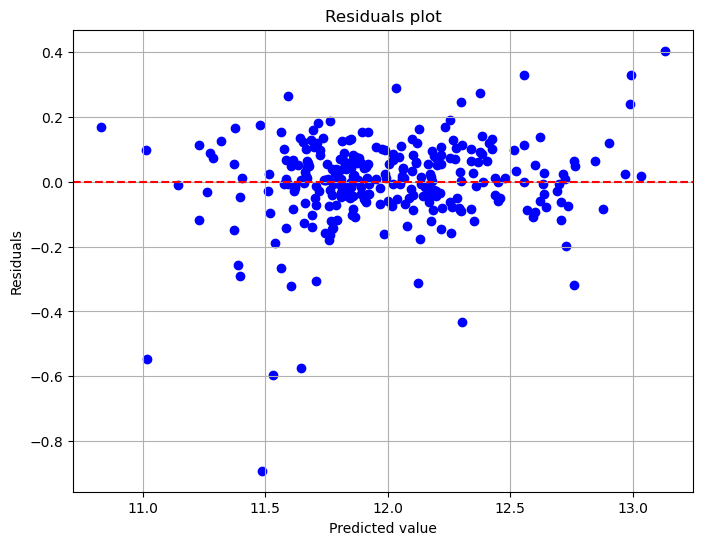

In [27]:
residuals = y_test - y_pred_test

print("Residuals mean:", residuals.mean())

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals plot')
plt.xlabel('Predicted value')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

## Feature importance

In [166]:
importance = model.feature_importances_

feature_names = X_train.columns.tolist()

sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

for i, (name, score) in enumerate(zip(sorted_feature_names, sorted_importance), 1):
    print(f'{i}. {name}: {score:.2f}')

1. GrLivArea: 195.00
2. LotArea: 131.00
3. TotalBsmtSF: 121.00
4. OverallQual: 107.00
5. 1stFlrSF: 103.00
6. BsmtFinSF1: 100.00
7. YearBuilt: 92.00
8. GarageArea: 89.00
9. OpenPorchSF: 84.00
10. OverallCond: 71.00
11. GarageYrBlt: 67.00
12. MasVnrArea: 48.00
13. LotFrontage: 46.00
14. YearRemodAdd: 42.00
15. 2ndFlrSF: 39.00
16. WoodDeckSF: 39.00
17. MoSold: 37.00
18. BsmtUnfSF: 34.00
19. EnclosedPorch: 29.00
20. Functional_Typ: 28.00
21. SaleCondition_Abnorml: 27.00
22. GarageCars: 24.00
23. TotRmsAbvGrd: 23.00
24. Condition1_Norm: 20.00
25. Exterior1st_BrkFace: 19.00
26. MSSubClass: 19.00
27. Fireplaces: 18.00
28. Neighborhood_Edwards: 18.00
29. SaleCondition_Normal: 17.00
30. BsmtExposure_Gd: 16.00
31. FullBath: 15.00
32. Neighborhood_Crawfor: 15.00
33. SaleCondition_Family: 15.00
34. ScreenPorch: 13.00
35. KitchenQual_Ex: 13.00
36. BsmtCond_Fa: 13.00
37. Fence_GdWo: 13.00
38. YrSold: 12.00
39. HalfBath: 12.00
40. CentralAir_Y: 11.00
41. KitchenAbvGr: 11.00
42. Condition1_Artery: 11.

### Do prediction

In [299]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(preprocessing)),  
    ('regressor', lgb.LGBMRegressor(random_state=42, **dart_params))  
])

pipeline.fit(X_train, y_train)

with open('LBMRegressor_house_prices.pickle', 'wb') as handle:
    pickle.dump(pipeline, handle)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3226
[LightGBM] [Info] Number o

In [300]:
with open('LBMRegressor_house_prices.pickle', 'rb') as handle:
    loaded_model = pickle.load(handle)

In [301]:
test = pd.read_csv("House-price/test.csv")

In [302]:
predictions = loaded_model.predict(test)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [304]:
submission = pd.DataFrame({'Id':test['Id'],'SalePrice':np.exp(predictions)})

In [305]:
submission.to_csv('LBMRegressor_submission.csv', index=False)